# Outline: #
- Initialize
    - Imports
    - Definitions, variables, and dictionaries

In [195]:
#%matplotlib widget
%matplotlib inline

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime

import matplotlib.animation as animation
from IPython import display

from matplotlib.animation import PillowWriter

print('all libraries imported! c;')

all libraries imported! c;


In [24]:
# close plots
for i in range(1000):
    plt.close(i)

In [189]:
DefBodiesDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
         7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
         9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
         8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
         1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
        -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
         1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
        -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
         4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
         1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
         1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])#Horizons System Ephemeris Data for 2000-01-01
            }

<class 'numpy.ndarray'>
total velocity: 
[ 9.61099610e-11 -1.73593721e-11 -1.42479696e-11]


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\199711664.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  xr1 = xr0 - f(xr0)/df(xr0)


<class 'numpy.ndarray'>
total velocity: 
[ 9.61099610e-11 -1.73593721e-11 -1.42479696e-11]
<class 'list'>
<class 'numpy.ndarray'>
total velocity: 
[ 9.61099610e-11 -1.73593721e-11 -1.42479696e-11]


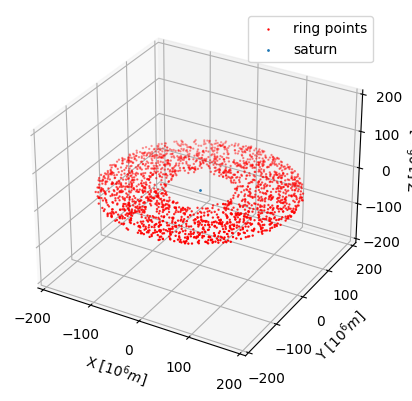

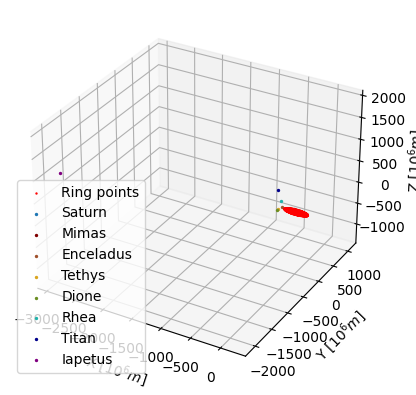

System already initialized. Continuing
array([5.68340000e+20, 3.75094000e+13, 1.08031800e+14, 6.17495900e+14,
       1.09548680e+15, 2.30648540e+15, 1.34518035e+17, 1.80565910e+15])
array([[ 1.95683334e-01, -2.07967708e-01,  8.89114822e-02],
       [-1.12774495e+02,  1.37769404e+02, -6.15442605e+01],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03]])
array([[ 1.00277971e-06,  7.10278640e-07, -4.62344314e-07],
       [-1.11522198e-02, -7.32502777e-03,  4.48190527e-03],
       [ 3.41978928e-04, -1.11706534e-02,  5.81982970e-03],
       [ 7.61827793e-03, -7.81392640e-03,  3.11628010e-03],
       [ 8.79997348e-03, -4.55139056e-03,  1.52685662e-03],
       [-5.06391284e-03, -5.78324261e

C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\199711664.py:712: RuntimeWarning: divide by zero encountered in reciprocal
  invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)


snapshot #1 taken & test element -58.19699826059201
snapshot #2 taken & test element 41.076089751904675
snapshot #3 taken & test element -24.23886724796174
snapshot #4 taken & test element 7.469974263004372
snapshot #5 taken & test element 10.11749255104246
snapshot #6 taken & test element -28.42709244818516
snapshot #7 taken & test element 45.31211304996277
snapshot #8 taken & test element -61.8196829690864
snapshot #9 taken & test element 76.51123656205355
snapshot #10 taken & test element -88.59603121907783
snapshot #11 taken & test element 99.95440291135198
snapshot #12 taken & test element -109.1251453974194
snapshot #13 taken & test element 115.92911362963704
snapshot #14 taken & test element -120.10011476344198
snapshot #15 taken & test element 121.64118922757909
snapshot #16 taken & test element -120.56135504717072
snapshot #17 taken & test element 117.07545939945061
snapshot #18 taken & test element -111.18766106989074
snapshot #19 taken & test element 102.18689584801939
snaps

In [196]:
'''README
    Units:
Force: N
Distance: Mm (megameters)
Mass: Gg (Gigagrams)        

m   --> Mm  *e-6
kg  --> Gg  *e-6

Constants in new units from SI units:
Gravitational constant 6.6726e-11  N m2 kg-2        --> 6.6726e-11  N Mm2 Gg-2
Saturn Mass            5.6834e26   kg               --> 5.6834e20   Gg

'''
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])



genLimits = np.array([60.3, 185.5]) #goes in constants dict
def flatAreaPDF(x):
    genLimits = ConstantsDict.get('Generation Limits')
    norm = 1 / (np.pi*(genLimits[1]**2 - genLimits[0]**2))
    out = norm* 2* np.pi*(np.heaviside((x-genLimits[0]),0) - np.heaviside((x-genLimits[1]),0))* x
    return out
def flatAreaCDF(x):
    genLimits = ConstantsDict.get('Generation Limits')
    norm = 1 / (np.pi*(genLimits[1]**2 - genLimits[0]**2))
    out = norm* np.pi*(np.heaviside((x-genLimits[0]),0)*(x**2 -genLimits[0]**2) - np.heaviside((x-genLimits[1]),0)*(x**2 -genLimits[1]**2))
    return out
def NewtonRaphsonFlatArea(f, df, x0, tolerance):
    '''
       finds a root of the equation f(x)=0, df is the derivative of f.
       The function should stops iterating when 
       
            | x_{i+1} - x_{i} | < tolerance
            
        and return an array with all the x_i values.
        
        x_0 is the starting point.         
    '''
    # YOUR CODE HERE
    genLimits = ConstantsDict.get('Generation Limits')
    output = np.array([])
    xr0 = x0
    xr1 = xr0 - f(xr0)/df(xr0)
    output = np.append(output,[xr0,xr1])
    while abs(xr1 - xr0) > tolerance:
        xr0 = xr1
        xr1 = xr0 - f(xr0)/df(xr0)
        if xr1 > genLimits[1]:
            xr1 = genLimits[1]
        elif xr1 < genLimits[0]:
            xr1 = genLimits[0]
        output = np.append(output,xr1)
    return output

def initParameters(mode): #WHAT IS A GOOD WAY TO PASS MANY PARAMETERS INTO AN INITIALIZATION FUNCTION??
    global ParamsDict
    ParamsDict = {
        'numberOfMoons': mode[0].count(1),
        'moonsList': mode[0],
        'moonsOrbitShape': mode[1],
        'moonsOrbitType': mode[2],
        'ringParticleNumber': mode[3],
        'initialDistributionType': mode[4],
        'ringLimits': mode[5]
    }
    return None
def calculateRingPlaneDir(): #calculates ring elements and adds them to ConstantsDict
    v1 = ConstantsDict.get('AegaeonElements')[0][0:3]
    v2 = ConstantsDict.get('AegaeonElements')[1][0:3]
    v1 = v1/np.sqrt(np.dot(v1,v1))
    v2 = v2/np.sqrt(np.dot(v2,v2))
    normalVector = np.cross(v1, v2)
    angle = np.arccos(np.dot(normalVector, [0,0,1])/np.sqrt(np.dot(normalVector,normalVector)))
    node = np.cross([0,0,1], normalVector)
    node = node/np.sqrt(np.dot(node,node))
    ConstantsDict.update({'ringAngle': angle, 'ringNode': node})
    return None
def circularizeMoonElements(debug=[]):
    GravConst = ConstantsDict.get('Gravitational Constant')
    SaturnMass = ConstantsDict.get('Saturn Mass')
    periods = np.array(BodiesDict.get('period'))
    radius = np.cbrt(GravConst*SaturnMass*periods**2/(4*np.pi**2))
    radius = radius*1e-4 #conversion factor for wacky units
    BodiesDict.update({'radius': radius})
    velocities = np.sqrt(GravConst*SaturnMass/radius)
    velocities = velocities*1e-6 #conversion factor for wacky units
    elements = BodiesDict.get('elements')
    if 'elementDiff' in debug:
        print('Old Elements: {}'.format(elements))
    for i in range(len(elements)):
        oPos = elements[i][0:3]
        nPos = oPos*radius[i]/np.sqrt(np.dot(oPos,oPos)) #circularize positions
        elements[i][0:3] = nPos
        oVel = elements[i][3:6]
        nVel = -oPos*np.dot(oPos,oVel)+oVel*np.dot(oPos,oPos) #using vector triple product
        nVel = nVel*velocities[i]/np.sqrt(np.dot(nVel,nVel)) #set new velocity magnitude and direction
        elements[i][3:6] = nVel
    if 'elementDiff' in debug:
        print('Circularized Elements: {}'.format(elements))
    BodiesDict.update({'elements': elements,'radii': radius})
    return None
def calcBodyPositions(time): #returns array of positions of each body at given time. Only available under restricted orbit type
    periods = BodiesDict.get('period')
    trueAnomalies = BodiesDict.get('moonTrueAnomalies')
    moonInclinations = BodiesDict.get('moonInclinations')
    moonNodes = BodiesDict.get('moonNodes')
    moonMasses = BodiesDict.get('mass')
    saturnMass = ConstantsDict.get('Saturn Mass')
    radii = BodiesDict.get('radii')
    #calculate moons positions
    positions = np.zeros((0,3))
    saturnDisplacement = np.zeros((1,3))
    for i in range(len(periods)):
        rotationMatrix = rotation_matrix(moonNodes[i],moonInclinations[i])
        inPlanePos = radii[i]*np.array([np.cos(2*np.pi*time/periods[i] + trueAnomalies[i]), np.sin(2*np.pi*time/periods[i] + trueAnomalies[i]),0])
        pos = np.matmul(rotationMatrix, inPlanePos)
        pos = np.array([pos])
        positions = np.append(positions, pos,0)
        newDisplacement = -pos*moonMasses[i]/saturnMass
        saturnDisplacement = saturnDisplacement + newDisplacement*(saturnMass + moonMasses[i])
    saturnDisplacement = saturnDisplacement/(saturnMass + np.sum(moonMasses))
    return positions, saturnDisplacement

def createBodyArrays(debug=[]): #bodyShapeElements
    # Gets elements from Constant and body dicts and creates an array of elements to be added to bodiesDict
    SaturnElements = [ConstantsDict.get('SaturnElements')[0:6]]
    temp = BodiesDict.get('elements')
    temp = temp[:,0:6]
    BodyArray = np.concatenate((SaturnElements,temp))
    BodiesDict.update({'Body Elements': BodyArray})
    if 'bodyShapeElements' in debug:
        print(SaturnElements)
        print(np.shape(SaturnElements))
        print(np.shape(temp))
        print(np.shape(BodyArray))
    return None
def removeNetMomentum(debug=[]):
    SaturnElements = ConstantsDict.get('SaturnElements')
    SaturnMass = ConstantsDict.get('Saturn Mass')
    elements = BodiesDict.get('elements')
    bodyMasses = np.array(BodiesDict.get('mass'))

    totalMass = np.sum(bodyMasses) + SaturnMass
    SaturnVelocity = SaturnElements[3:6]
    bodyVelocities = elements[:,3:6]
    momenta = bodyVelocities * bodyMasses [...,None]
    momenta = np.sum(momenta,axis=0) + SaturnMass * SaturnVelocity
    totalVelocity = momenta / totalMass
    print('total velocity: \n{}'.format(totalVelocity))

    SaturnVelocity = SaturnVelocity - totalVelocity
    bodyVelocities = bodyVelocities - totalVelocity[None,...]
    SaturnElements[3:6] = SaturnVelocity
    elements[:,3:6] = bodyVelocities
    ConstantsDict.update({'SaturnElements': SaturnElements})
    BodiesDict.update({'elements': elements})

    #fill in when doing n-body/elliptical simulations
    return None

def initConstants(localMode):
    global ConstantsDict
    match localMode:
        case 'restricted':
            genLimits = np.array([60.3, 185.5])
            ConstantsDict = {
                'Gravitational Constant': 6.6726e-11,           #unreferenced
                'Saturn Mass': 5.6834e20,                       #from Horizon's Ephemeris, in gigagrams
                'Saturn Radius': 5.8232e1,                      #from Horizon's Ephemeris, in megameters
                'SaturnElements': np.array([ 1.95683334e-01, -2.07967708e-01,  8.89114822e-02,  1.00287582e-03,
                7.10261281e-04, -4.62358562e-04,  9.97617585e-07,  2.99078228e-01,
                2.48285806e-08]),
                'AegaeonElements': np.array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
                -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
                 5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
                [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
                -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
                 5.58089452e-01,  1.67311008e+05, -2.30249816e-02]]), #Aegaeon Elements to calculate ring angular momentum vector direction
                'Generation Limits': genLimits
            }
        case 'unrestricted':
            cCoeffs = np.array([1/(2*(2-np.cbrt(2))),(1-np.cbrt(2))/(2*(2-np.cbrt(2))),(1-np.cbrt(2))/(2*(2-np.cbrt(2))),1/(2*(2-np.cbrt(2)))])
            dCoeffs = np.array([1/(2-np.cbrt(2)), -np.cbrt(2)/(2-np.cbrt(2)), 1/(2-np.cbrt(2)), 0])
            genLimits = np.array([60.3, 185.5])
            ConstantsDict = {
                'Gravitational Constant': 6.6726e-11,           #unreferenced
                'Saturn Mass': 5.6834e20,                       #from Horizon's Ephemeris, in gigagrams
                'Saturn Radius': 5.8232e1,                      #from Horizon's Ephemeris, in megameters
                'SaturnElements': np.array([ 1.95683334e-01, -2.07967708e-01,  8.89114822e-02,  1.00287582e-06,
                7.10261281e-07, -4.62358562e-07,  9.97617585e-07,  2.99078228e-01,
                2.48285806e-08]),
                'AegaeonElements': np.array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
                -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
                 5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
                [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
                -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
                 5.58089452e-01,  1.67311008e+05, -2.30249816e-02]]), #Aegaeon Elements to calculate ring angular momentum vector direction
                'c Coefficients': cCoeffs,
                'd Coefficients': dCoeffs,
                'Generation Limits': genLimits,
                'Boundary Limits': np.array([60.3, 185.5])
            }
    calculateRingPlaneDir() #calculates ring elements and adds them to ConstantsDict
    return None

def initBodiesDictionary(mode,debug=[]):
    global BodiesDict
    match mode:
        case 'circularMimas':
            BodiesDict = {
                'name': ['Mimas'],
                'mass': [3.75094e13],
                'semiMajorAxis': [186], #JPL Mean elements
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04]]),
                'period': [81202.91773558],
            }
            circularizeMoonElements(debug)
            removeNetMomentum(debug) #Fill in later
        case 'circular':
            BodiesDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'semiMajorAxis1': [186, 238.4, 295, 377.7, 527.2, 1221.9, 3561.7], #JPL Mean elements
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
         7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
         9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
         8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
         1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
        -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
         1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
        -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
         4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
         1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
         1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])
            }
            circularizeMoonElements(debug)
            removeNetMomentum(debug) #Fill in later
        case 'elliptical':
            BodiesDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
         7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
         9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
         8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
         1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
        -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
         1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
        -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
         4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
         1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
         1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])#Horizons System Ephemeris Data for 2000-01-01
            }
    mask = np.bool_(ParamsDict.get('moonsList'))
    print(type(mask))
    for element in BodiesDict:
        test = np.array(BodiesDict.get(element))
        out = test[mask]
        BodiesDict.update({element: out})
    removeNetMomentum(debug)
    return None

def initRings(mode, debug=[]): #creates correctly oriented ring distribution using of shape (3, #of particles)
    ringsPartNum = mode[0]
    ringsType = mode[1]
    ringLimits = mode[2]
    match ringsType:
        case 'flatRadial':
            saturnMass = ConstantsDict.get('Saturn Mass')
            gravConst = ConstantsDict.get('Gravitational Constant')
            radiiNum = int(np.ceil(ringsPartNum/ringLimits[2]))
            angles = np.linspace(0,2*np.pi,ringLimits[2])
            radii = np.linspace(ringLimits[0],ringLimits[1], radiiNum)
            
            velocities = np.sqrt(gravConst*saturnMass/radii)*1e-6
            initRArray = np.zeros((3,0))
            initVArray = np.zeros((3,0))
            for i in range(radiiNum):
                array1 = radii[i]*np.array([np.cos(angles),np.sin(angles),np.zeros(len(angles))])
                array2 = velocities[i]*np.array([-np.sin(angles),np.cos(angles),np.zeros(len(angles))])
                if 'arrayShapes' in debug:
                    print('array1 shape: {}'.format(np.shape(array1)))
                    print('array2 shape: {}'.format(np.shape(array2)))
                    print('initRArray shape: {}'.format(np.shape(initRArray)))
                    print('initVArray shape: {}'.format(np.shape(initVArray)))
                initRArray = np.append(initRArray, array1,1)
                initVArray = np.append(initVArray, array2,1)
            if 'init' in debug:
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(initRArray[0], initRArray[1], initRArray[2], s=0.5, label='ring points',color='red')
                saturnPos = ConstantsDict.get('SaturnElements')[0:3]
                ax.scatter(*saturnPos, s = 1, label='saturn')

                ax.legend()
                ax.set_xlabel('X [$10^6 m$]')
                ax.set_ylabel('Y [$10^6 m$]')
                ax.set_zlabel('Z [$10^6 m$]')
                set_axes_equal(ax)
                plt.show()
        case 'flatArea':
            saturnMass = ConstantsDict.get('Saturn Mass')
            gravConst = ConstantsDict.get('Gravitational Constant')
            radii = np.zeros(ringsPartNum)
            thetas = np.random.uniform(0,2*np.pi,size=(ringsPartNum))
            for i in range(ringsPartNum):
                random = np.random.random()
                def flatAreaCDFShifted(input):
                    return flatAreaCDF(input) - random
                root = NewtonRaphsonFlatArea(flatAreaCDFShifted,flatAreaPDF,125, 1e-6)
                root = root[-1]
                radii[i] = root
            velocities = np.sqrt(gravConst*saturnMass/radii)*1e-6
            initRArray = np.array([radii*np.cos(thetas),radii*np.sin(thetas),np.zeros(ringsPartNum)])
            initVArray = np.array([velocities*(-1)*np.sin(thetas),velocities*np.cos(thetas),np.zeros(ringsPartNum)])
            if 'init' in debug:
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(initRArray[0], initRArray[1], initRArray[2], s=0.5, label='ring points',color='red')
                saturnPos = ConstantsDict.get('SaturnElements')[0:3]
                ax.scatter(*saturnPos, s = 1, label='saturn')

                ax.legend()
                ax.set_xlabel('X [$10^6 m$]')
                ax.set_ylabel('Y [$10^6 m$]')
                ax.set_zlabel('Z [$10^6 m$]')
                set_axes_equal(ax)
                plt.show()
    axis = ConstantsDict.get('ringNode')
    angle = ConstantsDict.get('ringAngle')
    rotationMatrix = rotation_matrix(axis, angle)
    outRArray = np.matmul(rotationMatrix, initRArray) #initRArray: (3,num)
    outVArray = np.matmul(rotationMatrix, initVArray)
    outRArray = np.swapaxes(outRArray,0,1) #outRArray: (num,3)
    outVArray = np.swapaxes(outVArray,0,1)
    if 'out' in debug:
        ax = plt.figure().add_subplot(projection='3d')
        data = np.swapaxes(outRArray,0,1)
        ax.scatter(data[0], data[1], data[2], s=0.5, label='Ring points',color='red')
        saturnPos = ConstantsDict.get('SaturnElements')[0:3]
        ax.scatter(*saturnPos, s = 2, label='Saturn')
        names = BodiesDict.get('name')
        colors = BodiesDict.get('color')
        elements = BodiesDict.get('elements')
        for i in range(len(colors)):
            ax.scatter(*elements[i][0:3], s = 2, label=names[i], color=colors[i])
        ax.legend()
        ax.set_xlabel('X [$10^6 m$]')
        ax.set_ylabel('Y [$10^6 m$]')
        ax.set_zlabel('Z [$10^6 m$]')
        set_axes_equal(ax)
        plt.show()
    return outRArray, outVArray

def initOrbitType(mode,debug=[]): #updates dicts to accommodate restricted orbit type
    match mode:
        case 'restricted':
            elements = BodiesDict.get('elements')
            moonInclinations = np.array([])
            moonTrueAnomalies = np.array([])
            moonNodes = np.zeros((0,3))
            for i in range(len(elements)):
                pos = elements[i][0:3]
                vel = elements[i][3:6]
                normal = np.cross(pos,vel)
                angle = np.arccos(np.dot(normal, [0,0,1])/np.sqrt(np.dot(normal,normal)))
                moonInclinations = np.append(moonInclinations, angle)
                node = np.cross([0,0,1],normal)
                node = node/np.sqrt(np.dot(node,node))
                node = np.array([node])
                moonNodes = np.append(moonNodes,node,0)
                rotationMatrix = rotation_matrix(node[0], -angle)
                inPlanePos = np.matmul(rotationMatrix, pos)
                #print(inPlanePos)
                trueAnomaly = np.arctan2(inPlanePos[1],inPlanePos[0])
                moonTrueAnomalies = np.append(moonTrueAnomalies, trueAnomaly)
                
            if 'moonNodesAngles' in debug:
                print(moonInclinations)
                print(np.shape(moonNodes))
                print('node vectors: {}'.format(moonNodes))
                print('true anomaly angles: {}'.format(moonTrueAnomalies))
            BodiesDict.update({'moonNodes': moonNodes,'moonInclinations': moonInclinations,'moonTrueAnomalies': moonTrueAnomalies}) #moon orbit inclination, node, and true anomalies at time 0 added
        case 'unrestricted':
            createBodyArrays(debug)
            BodyMasses = np.array([ConstantsDict.get('Saturn Mass')])
            BodyMasses = np.append(BodyMasses, BodiesDict.get('mass'))
            if 'bodyShapeElements' in debug:
                print(BodyMasses)
            BodiesDict.update({'Body Masses': BodyMasses})
    return None

def init(mode, debug=[]):
# pass list of moons to initialization, circular/elliptical, restricted/unrestricted
    initParameters(mode)
    initConstants(mode[2])
    initBodiesDictionary(mode[1],debug)#'elementDiff'
    initOrbitType(mode[2],debug)#'moonNodesAngles', 'bodyShapeElements'
    RingRArray, RingVArray = initRings(mode[3:6],debug)#'init','out','arrayShapes'
    return RingRArray, RingVArray

#              moons list , orbitShape, 3BP orbitType, #particles,distrShape,ringlims  particles per ring,
x0, x1 = init(([1,1,1,1,1,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
#init(([1,1,1,1,1,1,1], 'circular', 'restricted', 200, 'flatRadial', [84.77, 150.7022312, 20]), debug=['init','out'])


#print(np.shape(RingRArray))
#calcBodyPositions(3)

def ODESolve(mode, t0, tf, dt, snapshotNumber, initBool=True, limits=[0,0], debug=['progress']): #'progress',''
    match initBool:
        case True:
            RingRArray, RingVArray = init(([1,1,1,1,1,1,1], 'circular', 'restricted', 200, 'flatRadial', [84.77, 150.7022312, 20]), debug=['init','out'])
            print('no initialization found. System reinitialized')
        case False:
            plist = []
            print(type(plist))
            for value in ParamsDict.values():
                plist.append(value)
            plist = plist[1:7]
            RingRArray, RingVArray = init((plist), debug=['init','out'])
            print('System already initialized. Continuing')
            pass
    match mode:
        case 'solveSymp':
            gravConst = ConstantsDict.get('Gravitational Constant')
            BodyMasses = BodiesDict.get('Body Masses')
            BodyRArray = BodiesDict.get('Body Elements')[:,0:3]
            BodyVArray = BodiesDict.get('Body Elements')[:,3:6]
            numberOfMoons = ParamsDict.get('numberOfMoons')
            ringParticleNumber = ParamsDict.get('ringParticleNumber')
            cCoeffs = ConstantsDict.get('c Coefficients')
            dCoeffs = ConstantsDict.get('d Coefficients')
            boundaryLims = ConstantsDict.get('Boundary Limits')
            #print('Boundary limits: {}'.format(boundaryLims))

            print(repr(BodyMasses))
            print(repr(BodyRArray))
            print(repr(BodyVArray))

            tList = np.arange(t0,tf,dt)
            steps = int((tf-t0)/dt)

            snapshotIndices = np.linspace(t0,tf,snapshotNumber,endpoint=False)
            print(snapshotIndices)
            snapshotIndices = np.round(snapshotIndices/dt)
            snRingRArray = np.zeros((snapshotNumber,3))

            #snapshot arrays
            snRingRArray = np.zeros((snapshotNumber,ringParticleNumber,3))
            snRingVArray = np.zeros((snapshotNumber,ringParticleNumber,3))
            snSaturnArray = np.zeros((snapshotNumber,1,3))
            snMoonsArray = np.zeros((snapshotNumber,numberOfMoons,3))

            RingRArray = np.ma.masked_array(RingRArray)
            RingVArray = np.ma.masked_array(RingVArray)
            snRingRArray = np.ma.masked_array(snRingRArray)
            snRingVArray = np.ma.masked_array(snRingVArray)

            print('snapshot indices: \n {}'.format(snapshotIndices))
            print('total steps: {}'.format(steps))
            s = 0 #snapshot index
            t = tList[0]

            for i in range(steps):
                if i % (int(steps/20)) == 0 and 'progress' in debug:
                    n = int(round(i / steps, 2) * 100)
                    print('{} % complete'.format(n))
                if s>=0:
                    if snapshotIndices[s] <= i:
                        moonPositions, saturnPosition = BodyRArray[1:8], BodyRArray[0]

                        snRingRArray[s] = RingRArray
                        snRingVArray[s] = RingVArray
                        snSaturnArray[s] = saturnPosition
                        snMoonsArray[s] = moonPositions
                        if 'progress' in debug:
                            print('snapshot #{} taken & test element {}'.format(s,snRingRArray[s][0,0]))
                        if s != snapshotNumber-1:
                            s += 1
                        else:
                            s = -100
                #print(accNBody(u1, BodyMasses) *gravConst*1e-12)
                u1 = BodyRArray + cCoeffs[0]*BodyVArray*dt  #u is position, s is velocity, and w is acceleration all for bodies
                x1 = RingRArray + cCoeffs[0]*RingVArray*dt #x is position, v is velocity, and a is acceleration all for rings
                s1 = BodyVArray - dCoeffs[0]*accNBody(u1, BodyMasses)*dt *gravConst *1e-12 #whacky conversions
                v1 = RingVArray - dCoeffs[0]*accRings(u1, x1, BodyMasses)*dt *gravConst *1e-12
                u2 = u1 + cCoeffs[1]*s1*dt
                x2 = x1 + cCoeffs[1]*v1*dt
                s2 = s1 - dCoeffs[1]*accNBody(u2, BodyMasses)*dt *gravConst*1e-12
                v2 = v1 - dCoeffs[1]*accRings(u2, x2, BodyMasses)*dt *gravConst *1e-12
                u3 = u2 + cCoeffs[2]*s2*dt
                x3 = x2 + cCoeffs[2]*v2*dt
                BodyVArray = s2 - dCoeffs[2]*accNBody(u3, BodyMasses)*dt *gravConst*1e-12 #aka s3
                RingVArray = v2 - dCoeffs[2]*accRings(u3, x3, BodyMasses)*dt *gravConst *1e-12 #aka v3
                BodyRArray = u3 + cCoeffs[3]*BodyVArray*dt
                RingRArray = x3 + cCoeffs[3]*RingVArray*dt
                #BodyVArray = s3
                #RingVArray = v3

                #Runtime: 2m 48s with removal in snapshot
                distances = np.sqrt(np.sum(RingRArray**2,axis=-1))
                distances = np.ma.masked_outside(distances, boundaryLims[0],boundaryLims[1])
                mask = distances.mask
                mask = np.bool_(np.ones((1,3))*mask[...,None])
                RingRArray = np.ma.masked_array(RingRArray, mask=mask)
                RingVArray = np.ma.masked_array(RingVArray, mask=mask)

                # print(BodyRArray)
                # print(BodyVArray)

                '''
                w0 = d2t_r(t, RingRArray,constants0)   #u is position, v is velocity, and w is acceleration
                u1 = RingRArray + dt*RingVArray/2
                v1 = RingVArray + dt*w0/2
                w1 = d2t_r(t + dt/2, u1,constants0)
                u2 = RingRArray + dt*v1/2
                v2 = RingVArray + dt*w1/2
                w2 = d2t_r(t + dt/2, u2,constants0)
                u3 = RingRArray + dt*v2
                v3 = RingVArray + dt*w2
                w3 = d2t_r(t + dt, u3,constants0)

                RingRArray = RingRArray + dt*(RingVArray+ 2*v1 + 2*v2 + v3) / 6
                RingVArray = RingVArray + dt*(w0 + 2*w1 + 2*w2 + w3) / 6
                '''
                t = tList[i+1]
            i = 0
            print('{}'.format(BodyMasses[i]))
            return RingRArray, snRingRArray, snRingVArray, snSaturnArray, snMoonsArray, tList, snapshotIndices #ADD RETURN RingVArray

        case 'solveRK':
            #define locals
            gravConst = ConstantsDict.get('Gravitational Constant')
            saturnMass = ConstantsDict.get('Saturn Mass')
            periods = BodiesDict.get('period')
            trueAnomalies = BodiesDict.get('moonTrueAnomalies')
            moonInclinations = BodiesDict.get('moonInclinations')
            moonNodes = BodiesDict.get('moonNodes')
            moonMasses = BodiesDict.get('mass')
            radii = BodiesDict.get('radii')
            numberOfMoons = ParamsDict.get('numberOfMoons')
            ringParticleNumber = ParamsDict.get('ringParticleNumber')
            constants0 = (gravConst, saturnMass, moonMasses)
            
            tList = np.arange(t0,tf,dt)
            steps = int((tf-t0)/dt)
            
            snapshotIndices = np.linspace(t0,tf,snapshotNumber,endpoint=False)
            print(snapshotIndices)
            snapshotIndices = np.round(snapshotIndices/dt)
            snRingRArray = np.zeros((snapshotNumber,3))

            #snapshot arrays
            snRingRArray = np.zeros((snapshotNumber,3,ringParticleNumber))
            snRingVArray = np.zeros((snapshotNumber,3,ringParticleNumber))
            snSaturnArray = np.zeros((snapshotNumber,1,3))
            snMoonsArray = np.zeros((snapshotNumber,numberOfMoons,3))

            print(snapshotIndices)
            print('total steps: {}'.format(steps))
            s = 0 #snapshot index
            t = tList[0]

            for i in range(steps):
                if i % (int(steps/20)) == 0 and 'progress' in debug:
                    n = int(round(i / steps, 2) * 100)
                    print('{} % complete'.format(n))
                if s>=0:
                    if snapshotIndices[s] <= i:
                        moonPositions, saturnPosition = calcBodyPositions(t)
                        snRingRArray[s] = RingRArray
                        snRingVArray[s] = RingVArray
                        snSaturnArray[s] = saturnPosition
                        snMoonsArray[s] = moonPositions
                        print('snapshot #{} taken & test element {}'.format(s,snRingRArray[s][0,0]))
                        if s != snapshotNumber-1:
                            s += 1
                        else:
                            s = -100

                w0 = d2t_r(t, RingRArray,constants0)   #u is position, v is velocity, and w is acceleration
                u1 = RingRArray + dt*RingVArray/2
                v1 = RingVArray + dt*w0/2
                w1 = d2t_r(t + dt/2, u1,constants0)
                u2 = RingRArray + dt*v1/2
                v2 = RingVArray + dt*w1/2
                w2 = d2t_r(t + dt/2, u2,constants0)
                u3 = RingRArray + dt*v2
                v3 = RingVArray + dt*w2
                w3 = d2t_r(t + dt, u3,constants0)

                RingRArray = RingRArray + dt*(RingVArray+ 2*v1 + 2*v2 + v3) / 6
                RingVArray = RingVArray + dt*(w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1] 
            return RingRArray, snRingRArray, snRingVArray, snSaturnArray, snMoonsArray, tList, snapshotIndices #ADD RETURN RingVArray

def d2t_r(time, inRArray, consts=(),debug=[]):
    if len(consts) == 0:
        gravConst = ConstantsDict.get('Gravitational Constant')
        saturnMass = ConstantsDict.get('Saturn Mass')
        moonMasses = BodiesDict.get('mass')
    else:
        gravConst = consts[0]
        saturnMass = consts[1]
        moonMasses = consts[2]
    moonPositions, saturnPosition = calcBodyPositions(time)

    outRingAArray = np.zeros(np.shape(inRArray))

    dSaturn = np.sqrt((inRArray[0]-saturnPosition[0][0])**2+(inRArray[1]-saturnPosition[0][1])**2+(inRArray[2]-saturnPosition[0][2])**2)
    saturnPosition = np.transpose(np.repeat(saturnPosition,len(inRArray[0]),0))
    outRingAArray = -saturnMass*(inRArray-saturnPosition)/dSaturn**3
    for i in range(len(moonPositions)):
        dMoon = np.sqrt((inRArray[0]-moonPositions[i][0])**2+(inRArray[1]-moonPositions[i][1])**2+(inRArray[2]-moonPositions[i][2])**2)
        pos = np.transpose(np.repeat([moonPositions[i]],len(inRArray[0]),0))
        outRingAArray = outRingAArray - moonMasses[i]*(inRArray-pos)/dMoon**3
    outRingAArray = outRingAArray*gravConst*1e-12
    return outRingAArray
#test = d2t_r(10, x0)
#print(test)

def accNBody(inRNBodyArray, masses):
    dim = len(inRNBodyArray)
    DistMatr = np.tile(inRNBodyArray,(dim,1,1))
    DistMatr = DistMatr - np.swapaxes(DistMatr,0,1)
    invSqrDist = DistMatr**2
    invSqrDist = np.sum(invSqrDist,axis=-1) ** (3/2)
    invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)
    OutANBodyArray = DistMatr *invSqrDist[...,None]

    masses1 = masses[...,None,None]
    OutANBodyArray = OutANBodyArray * masses1
    OutANBodyArray = np.sum(OutANBodyArray, axis=0)
    #OutANBodyMatr = OutANBodyArray * gravConst *1e-12
    return OutANBodyArray

def accRings(inRNBodyArray, inRingRArray, masses):
    DistMatr = inRingRArray[:,None,:] - inRNBodyArray[None,...]
    invSqrDist = DistMatr**2
    invSqrDist = np.sum(invSqrDist,axis=-1) ** (3/2)
    invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)
    OutRingAArray = invSqrDist[...,None] * DistMatr * masses[...,None]
    OutRingAArray = np.sum(OutRingAArray, axis=1)
    '''
    DistMatr = np.tile(inRNBodyArray,(dim,1,1))
    DistMatr = DistMatr - np.swapaxes(DistMatr,0,1)
    invSqrDist = DistMatr**2
    invSqrDist = np.sum(invSqrDist,axis=-1) ** (3/2)
    invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)
    OutANBodyMatr = DistMatr * invSqrDist[...,None]

    masses1 = masses[...,None]
    OutANBodyMatr = OutANBodyMatr * masses1
    OutANBodyMatr = np.sum(OutANBodyMatr, axis=0)
    '''
    #OutANBodyMatr = OutANBodyMatr * gravConst *1e-12
    return OutRingAArray



TotalFrames = 3000
Period = 10*DefBodiesDict.get('period')[6]
conversion = Period/TotalFrames/3600/24

np.random.seed(1234)
x0, x1 = init(([1,1,1,1,1,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('TotalRingR', XsnRingRArray)
np.save('TotalRingV', XsnRingVArray)
np.save('TotalSat', XsnSaturnArray)
np.save('TotalMoons', XsnMoonsArray)
print('Total Saved c;')


np.random.seed(1234)
x0, x1 = init(([0,1,1,1,1,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('MimasRingR', XsnRingRArray)
np.save('MimasRingV', XsnRingVArray)
np.save('MimasSat', XsnSaturnArray)
np.save('MimasMoons', XsnMoonsArray)
print('Mimas Saved c;')

np.random.seed(1234)
x0, x1 = init(([1,0,1,1,1,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('EnceladusRingR', XsnRingRArray)
np.save('EnceladusRingV', XsnRingVArray)
np.save('EnceladusSat', XsnSaturnArray)
np.save('EnceladusMoons', XsnMoonsArray)
print('Enceladus Saved c;')

np.random.seed(1234)
x0, x1 = init(([1,1,0,1,1,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('TethysRingR', XsnRingRArray)
np.save('TethysRingV', XsnRingVArray)
np.save('TethysSat', XsnSaturnArray)
np.save('TethysMoons', XsnMoonsArray)
print('Tethys Saved c;')

np.random.seed(1234)
x0, x1 = init(([1,1,1,0,1,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('DioneRingR', XsnRingRArray)
np.save('DioneRingV', XsnRingVArray)
np.save('DioneSat', XsnSaturnArray)
np.save('DioneMoons', XsnMoonsArray)
print('Dione Saved c;')

np.random.seed(1234)
x0, x1 = init(([1,1,1,1,0,1,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('RheaRingR', XsnRingRArray)
np.save('RheaRingV', XsnRingVArray)
np.save('RheaSat', XsnSaturnArray)
np.save('RheaMoons', XsnMoonsArray)
print('Rhea Saved c;')

np.random.seed(1234)
x0, x1 = init(([1,1,1,1,1,0,1], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('TitanRingR', XsnRingRArray)
np.save('TitanRingV', XsnRingVArray)
np.save('TitanSat', XsnSaturnArray)
np.save('TitanMoons', XsnMoonsArray)
print('Titan Saved c;')

np.random.seed(1234)
x0, x1 = init(([1,1,1,1,1,1,0], 'elliptical', 'unrestricted', 2000, 'flatArea', [84.77, 150.7022312, 20]),debug=[])
XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)
display.clear_output()
plt.close('all')
np.save('IapetusRingR', XsnRingRArray)
np.save('IapetusRingV', XsnRingVArray)
np.save('IapetusSat', XsnSaturnArray)
np.save('IapetusMoons', XsnMoonsArray)
print('Iapetus Saved c;')

print(conversion)
'''
Total
Mimas
Enceladus
Tethys
Dione
Rhea
Titan
Iapetus

All trials completed using 10*Iapetus orbital period, 2000 particles, 3000 snapshots, 100 second stepsize,
'''

'''
np.random.seed(1234)
TotalFrames = 3000
Period = 10*DefBodiesDict.get('period')[6]
conversion = Period/TotalFrames/3600/24

XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solveSymp', 0, Period, 100,TotalFrames,initBool = False)

XRArray = np.transpose(XRingRArray)
print(np.shape(XRArray))
XSaturnPos = XsnSaturnArray[-2][0]
XMoonsPos = XsnMoonsArray[-2]
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
ax.scatter(*XSaturnPos, s = 2, label='Saturn')
names = DefBodiesDict.get('name')
colors = DefBodiesDict.get('color')
for i in range(len(colors)):
    ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
ax.legend()
ax.set_xlabel('X [$10^6 m$]')
ax.set_ylabel('Y [$10^6 m$]')
ax.set_zlabel('Z [$10^6 m$]')
set_axes_equal(ax)
plt.show()
'''

In [17]:
np.save('TotalRingR', XsnRingRArray)
np.save('TotalRingV', XsnRingVArray)
np.save('TotalSat', XsnSaturnArray)
np.save('TotalMoons', XsnMoonsArray)

'''
Total
Mimas
Enceladus
Tethys
Dione
Rhea
Titan
Iapetus

All trials completed using 10*Iapetus orbital period, 2000 particles, 3000 snapshots, 100 second stepsize
'''

#np.save('10P6-10-30000RingR',XsnRingRArray)
#np.save('10P6-10-30000RingV',XsnRingVArray)
#np.save('10P6-10-30000Sat',XsnSaturnArray)
#np.save('10P6-10-30000Moons',XsnMoonsArray)

In [103]:
import matplotlib.animation as animation
from IPython import display

def AnimatedOrbitalPlot1(numOfFrames, playbackInterval, snapshotInterval, halfBoxLength, save=False):

    halfBoxLength = 200
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]

    def animate(frNum):
        SaturnFrame = XsnSaturnArray[frNum]
        RingsFrame = XsnRingRArray[frNum]
        RingsFrame = np.swapaxes(RingsFrame,0,1)
        RingLine.set_data(RingsFrame[0],RingsFrame[1])
        RingLine.set_3d_properties(RingsFrame[2])
        SaturnLine.set_data(SaturnFrame[0,0],SaturnFrame[0,1])
        SaturnLine.set_3d_properties(SaturnFrame[0,2])
        for i in range(len(MoonLines)):
            frame = XsnMoonsArray[frNum,i]
            MoonLines[i].set_data(frame[0],frame[1])
            MoonLines[i].set_3d_properties(frame[2])
        title.set_text('Saturn System at time, t={:0>10.3f} days'.format(frNum*snapshotInterval))  #set snapshotInterval according to the snapshot interval and total time interval
        ax.legend(bbox_to_anchor=(-0.2,0.6), loc=6)
        return title, SaturnLine, RingLine, *MoonLines,

    def initializePlot():
        global fig, ax, title, SaturnLine, RingLine, MoonLines
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        title = ax.set_title('INITIAL TITLE')

        ax.legend(bbox_to_anchor=(-0.2,0.6), loc=6)
        ax.set_xlabel('X [$10^6 m$]')
        ax.set_ylabel('Y [$10^6 m$]')
        ax.set_zlabel('Z [$10^6 m$]')
        set_axes_equal(ax)
        ax.set_xlim3d([plotLims[0], plotLims[1]])
        ax.set_ylim3d([plotLims[2], plotLims[3]])
        ax.set_zlim3d([plotLims[4], plotLims[5]])
        ax.view_init(27,-10)
        ax.dist = 12

        names = DefBodiesDict.get('name')
        colors = DefBodiesDict.get('color')

        temp = XsnRingRArray[0]
        temp = np.swapaxes(temp,0,1)
        SaturnLine, = ax.plot(*XsnSaturnArray[0,0], label='Saturn', linestyle='', marker='o', markersize=2)
        RingLine, = ax.plot(temp[0].compressed(),temp[1].compressed(),temp[2].compressed(), label='Ring points', color='red', linestyle='', marker='o', markersize=0.5)
        MoonLines = []
        for index, datum in enumerate(XsnMoonsArray[0]):
            line, = ax.plot(datum[0], datum[1], datum[2], label=names[index], color=colors[index], linestyle='', marker='o', markersize=2)
            MoonLines.append(line)
        return None
    initializePlot()

    anim = animation.FuncAnimation(fig, animate, frames=numOfFrames,
                                interval=playbackInterval, blit=True)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
    return None

def AnimatedDistrPlot1(numOfFrames, playbackInterval, snapshotInterval, plotLims, bins, save=False):
    ringParticleNumber = ParamsDict.get('ringParticleNumber')
    temp = np.transpose(XsnRingRArray, (1,0,2))
    XsnRadii = np.sqrt(temp[0]**2 + temp[1]**2 + temp[2]**2)
    print('XsnRadii shape: {}'.format(np.shape(XsnRadii)))
    def animate(frNum):
        frame = XsnRadii[frNum]
        plt.cla()
        plt.hist(frame, bins=bins, range=(plotLims[0],plotLims[1]), rwidth=0.9)
        plt.xlabel('Distance from Saturn System Barycentre [$10^6\:m$]')
        plt.ylabel('Number of Particles')
        plt.title('Ring Particle Distribution at Time, t={:0>10.3f} days'.format(frNum*snapshotInterval))
        return title,
    def initializePlot():
        global fig, ax, title, hist
        fig = plt.figure()
        title = ax.set_title('INITIAL TITLE')
        hist = plt.hist(XsnRadii[0], bins=bins, range=(plotLims[0],plotLims[1]), rwidth=0.9)
        
        plt.xlabel('Distance from Saturn System Barycentre [$10^6\:m$]')
        plt.ylabel('Number of Particles')
        return None
    initializePlot()

    anim = animation.FuncAnimation(fig, animate, frames=numOfFrames,
                                   interval=playbackInterval,blit=True)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
    return None



#AnimatedDistrPlot1(numberOfFrames, 40, conversion, [70,160,0,30], 30)
AnimatedOrbitalPlot1(TotalFrames, 40, conversion, 200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\3399623525.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\3399623525.py:15: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  SaturnLine.set_data(SaturnFrame[0,0],SaturnFrame[0,1])
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\3399623525.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  MoonLines[i].set_data(frame[0],frame[1])
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\3399623525.py:15: MatplotlibDeprecationWarning: Setting data with a no

In [15]:
print('Saturn Snapshot Array Shape: {}'.format(np.shape(XsnSaturnArray)))
print('Moons Snapshot Array Shape: {}'.format(np.shape(XsnMoonsArray)))
print('Ring Snapshot Array Shape: {}'.format(np.shape(XsnRingRArray)))
print('{:0>10.3f}'.format(000.103256))
x0 = np.array([0,1,2,3,4,5])

Saturn Snapshot Array Shape: (300, 1, 3)
Moons Snapshot Array Shape: (300, 7, 3)
Ring Snapshot Array Shape: (300, 3, 200)
000000.103
[0 1]


In [6]:
# importing required libraries 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 
# initializing a figure 

def animate(frame_number):
    #frame = np.transpose(data)[frame_number]
    # plots a sine graph
    for i in range(len(lines)):
        frame = data[i]
        lines[i].set_data(frame[0,frame_number],frame[1,frame_number])
        lines[i].set_3d_properties(frame[2,frame_number])
        lines[i].set_color('green')
    #line.set_data(frame[0], frame[1])
    #line.set_3d_properties(frame[2])
    #line.set_color('green')
    ax.set_xlim3d([-5,5])
    ax.set_ylim3d([-5,5])
    ax.set_zlim3d([-5,5])
    title.set_text('3D Test, time={}'.format(frame_number))
    return title, *lines, 

data = []
data1 = np.array([[1,2,3,4],[1,-1,-1,2],[3,0,-3,-1]])
data.append(data1)
data2 = np.array([[4,3,2,1],[2,-1,-1,1],[-1,-3,0,3]])
data.append(data2)
print('data shape: {}'.format(np.shape(data)))

fig = plt.figure()
ax = plt.axes(projection='3d') 
title = ax.set_title('TITLE')

lines = []
for datum in data:
    line, = ax.plot(datum[0][0], datum[1][0], datum[2][0], linestyle='', marker='o')
    print(np.shape(line))
    lines.append(line)

animate(2)

anim = animation.FuncAnimation(fig, animate, frames=4,  
                               interval=1000, blit=True) 
#fig.suptitle('Sine wave plot', fontsize=14) 
  
# converting to an html5 video 
video = anim.to_html5_video()

# embedding for the video 
html = display.HTML(video)

# draw the animation 
display.display(html)
plt.close()

data shape: (2, 3, 4)
()
()


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\3424075118.py:17: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lines[i].set_data(frame[0,frame_number],frame[1,frame_number])
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\3424075118.py:17: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lines[i].set_data(frame[0,frame_number],frame[1,frame_number])


In [4]:
# importing required libraries 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 
  
# initializing a figure 
fig = plt.figure() 
  
# labeling the x-axis and y-axis 
axis = plt.axes(xlim=(0, 4),  ylim=(-1.5, 1.5)) 
  
# initializing a line variable 
line, = axis.plot([], [], lw=3) 
  
def animate(frame_number): 
    x = np.linspace(0, 4, 1000) 
  
    # plots a sine graph 
    y = np.sin(2 * np.pi * (x - 0.01 * frame_number)) 
    line.set_data(x, y) 
    line.set_color('green')
    return line, 
  
  
anim = animation.FuncAnimation(fig, animate, frames=100,  
                               interval=20, blit=True) 
fig.suptitle('Sine wave plot', fontsize=14) 
  
# converting to an html5 video 
video = anim.to_html5_video() 
  
# embedding for the video 
html = display.HTML(video) 
  
# draw the animation 
display.display(html) 
plt.close() 

81200.0
[False False False ... False False False]
38
(3, 300)
3


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\1688410802.py:29: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


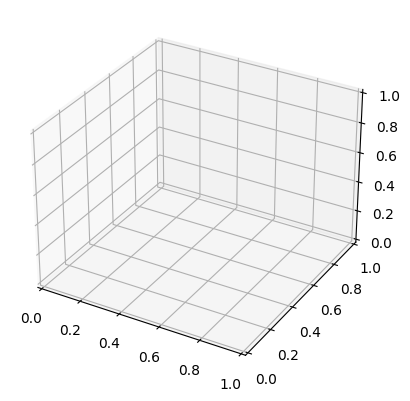

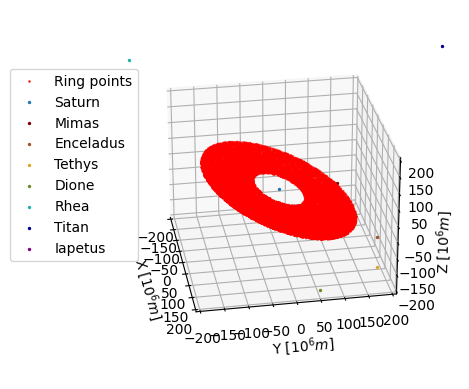

<Figure size 300x300 with 0 Axes>

In [109]:
from matplotlib.animation import FuncAnimation
from IPython import display

halfBoxLength = 200

#print(XsnRingRArray[1])
print(XtList[-1])
def plot1(index):
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]
    XRArray = np.transpose(XsnRingRArray[index])
    XSaturnPos = XsnSaturnArray[index][0]
    XMoonsPos = XsnMoonsArray[index]
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
    ax.scatter(*XSaturnPos, s = 2, label='Saturn')
    names = DefBodiesDict.get('name')
    colors = DefBodiesDict.get('color')
    for i in range(len(colors)):
        ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
    ax.legend(loc=4, bbox_to_anchor=(0.15,0.3))
    ax.set_xlabel('X [$10^6 m$]')
    ax.set_ylabel('Y [$10^6 m$]')
    ax.set_zlabel('Z [$10^6 m$]')
    set_axes_equal(ax)
    ax.set_xlim3d([plotLims[0], plotLims[1]])
    ax.set_ylim3d([plotLims[2], plotLims[3]])
    ax.set_zlim3d([plotLims[4], plotLims[5]])
    ax.view_init(27,-10)
    ax.dist = 12
    fig = plt.figure(figsize=(3,3))
    #plt.show()
    #plt.savefig('ring'+str(index))
    return fig

def plot2(index):
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]
    XRArray = np.transpose(XsnRingRArray[index])
    radii = 1
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
    ax.scatter(*XSaturnPos, s = 2, label='Saturn')
    names = DefBodiesDict.get('name')
    colors = DefBodiesDict.get('color')
    for i in range(len(colors)):
        ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
    ax.legend(loc=4, bbox_to_anchor=(0.15,0.3))
    ax.set_xlabel('X [$10^6 m$]')
    ax.set_ylabel('Y [$10^6 m$]')
    ax.set_zlabel('Z [$10^6 m$]')
    set_axes_equal(ax)
    ax.set_xlim3d([plotLims[0], plotLims[1]])
    ax.set_ylim3d([plotLims[2], plotLims[3]])
    ax.set_zlim3d([plotLims[4], plotLims[5]])
    ax.view_init(27,-10)
    ax.dist = 12
    fig = plt.figure(dpi=400)
    #plt.show()
    #plt.savefig('ring'+str(index))
    return fig

x0 = XsnRingRArray[-1,:,0].mask
print(XsnRingRArray[-1,:,0].mask)
for i in range(len(x0)):
    if x0[i] == True:
        print(i)
        break
    else:
        pass

#print(np.sum(XsnRingRArray[-1,:,:].mask))
#print(XsnRingRArray[:,38,0])
y0 = XsnRingRArray[:,38,:]#.compressed()
y0 = np.transpose(y0)
print(np.shape(y0))
#print(y0)
print(len(y0))
plt.axes(projection='3d')

#elev: 27, azim: -10, roll: 0
test = plot1(-1)
plt.show()
# for i in range(60):
#     plot1(i)



frame shape: (20000, 3)
(3, 3)
(3, 20000)
[-2.61528823e-15 -1.58163819e-15 -3.74752172e-15 ...  1.51366021e-15
  3.31110362e-16  4.74109366e-15]
-185.16377683092284
(20000,)
(20000,)
(20000,)
VelDiff shape: (3, 20000)
frame shape: (20000, 3)
(3, 3)
(3, 19865)
[-8.14994334e-04 -1.25511529e-03  1.49197919e-04 ... -1.58429383e-03
 -7.46874725e-05 -1.63968418e-03]
-184.4369644938037
(19865,)
(19865,)
(19865,)
VelDiff shape: (3, 19865)
frame shape: (20000, 3)
(3, 3)
(3, 19863)
[-1.32900207e-03 -8.40206765e-04  4.15480476e-05 ...  2.96436639e-04
 -4.43027240e-04  4.93615043e-04]
-184.38296021323967
(19863,)
(19863,)
(19863,)
VelDiff shape: (3, 19863)


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\1945637839.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg1.legendHandles:
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\1945637839.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg2.legendHandles:
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_4352\1945637839.py:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg3.legendHandles:


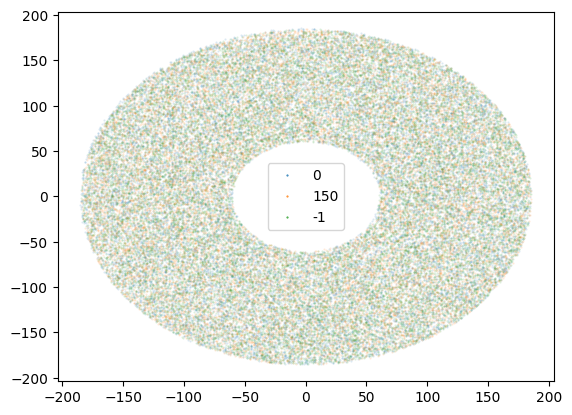

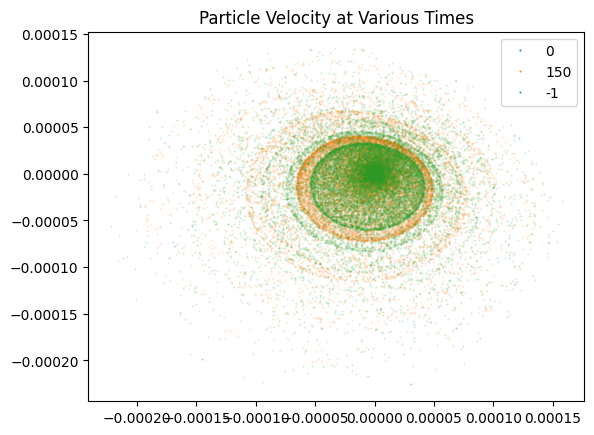

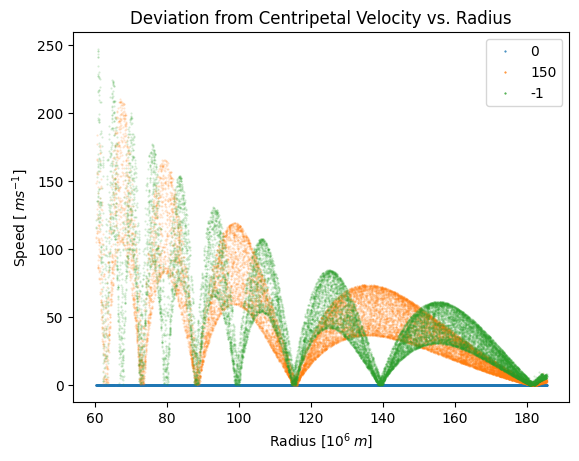

In [173]:
#print('< \n {} \n >'.format(XsnMoonsArray[0]))
#print('< \n {} \n >'.format(XsnMoonsArray[1]))
#print('< \n {} \n >'.format(XsnMoonsArray[2]))

def VelDifPlot(RArray, VArray, index):
    gravConst = ConstantsDict.get('Gravitational Constant')
    saturnMass = ConstantsDict.get('Saturn Mass')
    frameR = XsnRingRArray[index]
    frameV = XsnRingVArray[index]
    print('frame shape: {}'.format(np.shape(frameR)))
    frameR = frameR.compressed()
    frameV = frameV.compressed()
    dim = len(frameR)
    frameR = frameR.reshape((int(dim/3),3))
    frameV = frameV.reshape((int(dim/3),3))
    axis = ConstantsDict.get('ringNode')
    angle = ConstantsDict.get('ringAngle')
    rotationMatrix = rotation_matrix(axis, -angle)
    print(np.shape(rotationMatrix))

    frameR = np.matmul(rotationMatrix, np.transpose(frameR))
    frameV = np.matmul(rotationMatrix, np.transpose(frameV))

    print(np.shape(frameR))
    print(frameR[2,:])
    print(np.min(frameR[0,:]))
    plt.figure(1)
    plt.plot(frameR[0],frameR[1],linestyle='',marker='o',alpha=0.15,markersize=0.5,label=index)
    leg1 = plt.legend()
    for lh in leg1.legendHandles: 
        lh.set_alpha(1)
    
    thetas = np.arctan2(frameR[1],frameR[0])
    radii = np.sqrt(np.sum(np.transpose(frameR)**2,axis=-1))
    velocities = np.sqrt(gravConst*saturnMass/radii)*1e-6
    print(np.shape(thetas))
    print(np.shape(radii))
    print(np.shape(velocities))
    #initRArray = np.array([radii*np.cos(thetas),radii*np.sin(thetas),np.zeros(dim)])
    VelCent = np.array([velocities*(-1)*np.sin(thetas),velocities*np.cos(thetas),np.zeros(int(dim/3))])
    VelDiff = frameV - VelCent
    print('VelDiff shape: {}'.format(np.shape(VelDiff)))
    plt.figure(2)
    plt.title('Particle Velocity at Various Times')
    plt.plot(VelDiff[0],VelDiff[1],linestyle='',marker='o',alpha=0.2,markersize=0.5,label=index)
    leg2 = plt.legend()
    for lh in leg2.legendHandles: 
        lh.set_alpha(1)


    AbsVelDiff = np.sqrt(np.sum(VelDiff**2,axis=0))
    plt.figure(3)
    plt.title('Deviation from Centripetal Velocity vs. Radius')
    plt.plot(radii,AbsVelDiff*1e6,linestyle='',marker='o',alpha=0.2,markersize=0.5,label=index)
    plt.xlabel('Radius [$10^6 \: m$]')
    plt.ylabel('Speed [$ \: ms^{-1}$]')
    leg3 = plt.legend()
    for lh in leg3.legendHandles: 
        lh.set_alpha(1)

    return None

VelDifPlot(0)
VelDifPlot(150)
VelDifPlot(-1)

(60, 7, 3)
81200.0


TypeError: cannot unpack non-iterable Path3DCollection object

<Figure size 640x480 with 0 Axes>

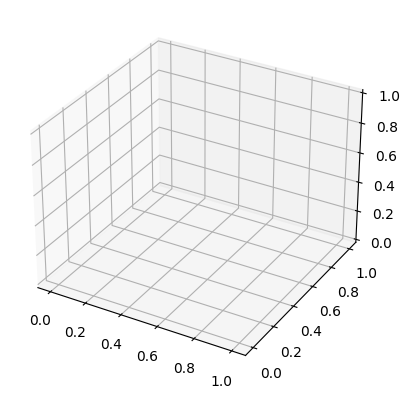

In [11]:
#print(XsnRingRArray[1])
print(np.shape(XsnMoonsArray))
print(XtList[-1])

halfBoxLength = 200
plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]
index = 59
indices = np.arange(0,60)


names = MoonsDict.get('name')
colors = MoonsDict.get('color')

fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
l1, = ax.scatter([], [], [], s=0.5, label='Ring points',color='red')
l2, = ax.scatter([], [], [], s = 2, label='Saturn')


ax.legend(bbox_to_anchor=(0.1,0.7))
ax.set_xlabel('X [$10^6 m$]')
ax.set_ylabel('Y [$10^6 m$]')
ax.set_zlabel('Z [$10^6 m$]')
set_axes_equal(ax)
ax.set_xlim3d([plotLims[0], plotLims[1]])
ax.set_ylim3d([plotLims[2], plotLims[3]])
ax.set_zlim3d([plotLims[4], plotLims[5]])
ax.view_init(27,-10)
ax.dist = 12
plt.show()
#elev: 27, azim: -10, roll: 0

anim = animation.FuncAnimation(fig, animate, frames=4,  
                               interval=100, blit=True) 
#fig.suptitle('Sine wave plot', fontsize=14) 
  
# converting to an html5 video 
video = anim.to_html5_video() 
  
# embedding for the video 
html = display.HTML(video) 
  
# draw the animation 
display.display(html) 
plt.close() 

"""metadata = dict(title='ringGif', artist='Keira')
writer = PillowWriter(fps=20, metadata=metadata)


with writer.saving(fig, 'ringOrbit.gif',200):
    for i in indices:
        XRArray = XsnRingRArray[i]
        XSaturnPos = XsnSaturnArray[i][0]
        XMoonsPos = XsnMoonsArray[i]

        ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
        ax.scatter(*XSaturnPos, s = 2, label='Saturn')
        for i in range(len(colors)):
            ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
        writer.grab_frame()"""

In [46]:
#print(XsnRingRArray[1])

indices = np.arange(0,60)

def SavePlot1(index):
    halfBoxLength = 200
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]

    XRArray = XsnRingRArray[index]
    XSaturnPos = XsnSaturnArray[index][0]
    XMoonsPos = XsnMoonsArray[index]
    names = MoonsDict.get('name')
    colors = MoonsDict.get('color')

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
    ax.scatter(*XSaturnPos, s = 2, label='Saturn')
    for i in range(len(colors)):
        ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])

    ax.legend(bbox_to_anchor=(-0.2,0.6), loc=6)
    ax.set_xlabel('X [$10^6 m$]')
    ax.set_ylabel('Y [$10^6 m$]')
    ax.set_zlabel('Z [$10^6 m$]')
    set_axes_equal(ax)
    ax.set_xlim3d([plotLims[0], plotLims[1]])
    ax.set_ylim3d([plotLims[2], plotLims[3]])
    ax.set_zlim3d([plotLims[4], plotLims[5]])
    ax.view_init(27,-10)
    ax.dist = 12
    #plt.show()
    plt.savefig('rings'+str(index))

    return None
def SavePlot2(index):
    
    return None

#SavePlot1(2)
for i in indices:
    #SavePlot1(i)
    #elev: 27, azim: -10, roll: 0

SyntaxError: incomplete input (4126826328.py, line 42)

In [ ]:
def ODESolve(t_0, t_f, dt, initBool, initModeTuple=None, progress='none'):
    match initBool:
        case True:
            init(initModeTuple)
        case False:
            pass
            

In [6]:
import os


In [74]:
'''print(os.listdir())
print('current working directory: {}'.format(os.getcwd()))
os.chdir('Ephemeris Data')'''
print(os.listdir())
print(os.getcwd())


['dione_horizons_results.txt', 'enceladus_horizons_results.txt', 'iapetus_horizons_results.txt', 'mimas_horizons_results.txt', 'rhea_horizons_results.txt', 'saturn_horizons_results.txt', 'tethys_horizons_results.txt', 'titan_horizons_results.txt']
c:\Users\Kenneth\Desktop\Stuff\Documents\Study\Durham\L3\3561 CPr\CPr-3BodyProblem\Ephemeris Data


In [103]:
separatorsList = [' X =', ' Y =', ' Z =', ' VX=', ' VY=', ' VZ=', ' LT=', ' RG=', ' RR=']
namesList = ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus']
elements = []

def readElements(name, mode): #Reads orbital elements out of a Horizons Ephemeris txt file
    file = open(name + '_horizons_results.txt', 'r')
    print(name + '.txt')
    outputlist = []
    contents = file.read()
    for i in range(len(separatorsList) - 1):
        temporary = contents
        temporary = temporary.split(separatorsList[i], mode)[mode]
        temporary = temporary.split(separatorsList[i+1], mode)[0]
        temporary = temporary.rstrip().lstrip()
        temporary = temporary.casefold()
        temporary = float(temporary)
        outputlist.append(temporary)
    temporary = contents
    temporary = temporary.split(separatorsList[-1], 2)[1]
    temporary = temporary[0:22]
    temporary = temporary.rstrip().lstrip()
    temporary = temporary.casefold()
    temporary = float(temporary)
    print(temporary)
    outputlist.append(temporary)

    #print(outputlist)
    return outputlist
'''for name in namesList:
    elements.append(readElements(name,1))
elements = np.array(elements)
print(elements)
elements = elements/1e3
print(repr(elements) == repr(MoonsDict.get('elements')))'''

elements = np.zeros((2,9))
elements[0] = np.array(readElements('Aegaeon',1))
elements[1] = np.array(readElements('Aegaeon',2))
print(repr(elements))

'''x = np.array(readElements('saturn'))
print(x)
x = x/1e3
print(x)
print(repr(x))'''


Aegaeon.txt
-0.02302498160477574
Aegaeon.txt
-0.02302498160477574
array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
        -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
         5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
       [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
        -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
         5.58089452e-01,  1.67311008e+05, -2.30249816e-02]])


"x = np.array(readElements('saturn'))\nprint(x)\nx = x/1e3\nprint(x)\nprint(repr(x))"

In [28]:
x0 = np.array([1,2,3])
x1 = np.array([np.cos(x0), np.sin(x0), np.zeros(len(x0))])
x1 = np.transpose(x1)

print(x1)
print(x1[1])
print(MoonsDict.get('elements')[0])

[[ 0.54030231  0.84147098  0.        ]
 [-0.41614684  0.90929743  0.        ]
 [-0.9899925   0.14112001  0.        ]]
[-0.41614684  0.90929743  0.        ]
[-1.12774495e+02  1.37769404e+02 -6.15442605e+01 -1.11522197e-02
 -7.32502779e-03  4.48190526e-03  6.28360667e-04  1.88377789e+02
 -1.44997560e-04]


In [ ]:
x0 = np.linspace(0,2*np.pi, 10)
x2 = np.zeros((3,0))
for i in range(5):
    x1 = np.array([np.cos(x0),np.sin(x0),np.zeros(len(x0))])
    print(np.shape(x2))
    print(np.shape(x1))
    x2 = np.append(x2, np.array(x1),1)
print(x2)

In [ ]:
x = np.zeros((3,0))
print(x)
for i in range(5):  
    x = np.append(x, np.transpose(np.array([[1,2,3]])),1)
    print(x)

In [16]:
x1 = ConstantsDict.get('AegaeonElements')[0][0:3]
x2 = ConstantsDict.get('AegaeonElements')[1][0:3]

x1 = x1/np.sqrt(np.dot(x1,x1))
x2 = x2/np.sqrt(np.dot(x2,x2))
print(x1)
print(x2)
angle0 = np.arccos(np.dot(x1, x2)/np.sqrt(np.dot(x1,x1))/np.sqrt(np.dot(x1,x1)))
print('angle0: {} rads, {} degs'.format(angle0, angle0/np.pi*180))
normalVector = np.cross(x1, x2)
print('normalVector: {}'.format(normalVector))
angle = np.arccos(np.dot(normalVector, [0,0,1])/np.sqrt(np.dot(normalVector,normalVector)))
print('angle: {} rads, {} degs'.format(angle, angle/(np.pi)*180))
node = np.cross(normalVector, [0,0,1])
node = node/np.sqrt(np.dot(node, node))
print('node vector:{}'.format(node))

[ 0.97179586  0.15670423 -0.1762288 ]
[-0.14267663  0.88232731 -0.44848847]
angle0: 1.4920665703374594 rads, 85.48911723289602 degs
ringPlaneVector: [0.08521144 0.46098297 0.87980005]
angle: 0.4895729056668093 rads, 28.05046125866456 degs
node vector:[ 0.98334145 -0.18176798  0.        ]


In [16]:
p = np.array([0.9424218, 1.370218, 1.887802, 2.736915, 4.518212, 15.945421, 79.33])
p = p*86164.091
print(repr(p))
print(MoonsDict.get('name'))

array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ])
['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus']


In [15]:
x0 = ConstantsDict.get('Gravitational Constant')
x1 = ConstantsDict.get('Saturn Mass')
x2 = 81202.91773558
res1 = np.cbrt(x0*x1*x2**2/(4*np.pi**2))
print('{}'.format(res1))
print('in Mm: {}'.format(res1*1e-4))
y0 = x0
y1 = x1*1e6
y2 = x2
print(np.cbrt(y0*y1*y2**2/(4*np.pi**2)))

1850243.7619752712
in Mm: 185.02437619752712
185024376.1975271


In [76]:
x0 = np.array([1,2,3])
x0 = [x0]
x1 = np.zeros((0,3))
for i in range(5):
    print(np.shape(x0))
    print(np.shape(x1))
    x1 = np.append(x1,x0,0)
    print(x1)

(1, 3)
(0, 3)
[[1. 2. 3.]]
(1, 3)
(1, 3)
[[1. 2. 3.]
 [1. 2. 3.]]
(1, 3)
(2, 3)
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
(1, 3)
(3, 3)
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
(1, 3)
(4, 3)
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


In [36]:
deltaT = 1.4
tFinal = 15.6
Nsteps = int((tFinal/deltaT))
print(Nsteps)

x = np.arange(0,tFinal,deltaT)
print(x)

numberofSnapshots = 5
snapshotInterval = tFinal/numberofSnapshots
y = np.linspace(0,tFinal,numberofSnapshots)
y0 = y/deltaT
y1 = np.round(y/deltaT)
print(y)
print(y0)
print(y1)

11
[ 0.   1.4  2.8  4.2  5.6  7.   8.4  9.8 11.2 12.6 14.  15.4]
[ 0.   3.9  7.8 11.7 15.6]
[ 0.          2.78571429  5.57142857  8.35714286 11.14285714]
[ 0.  3.  6.  8. 11.]


1
1


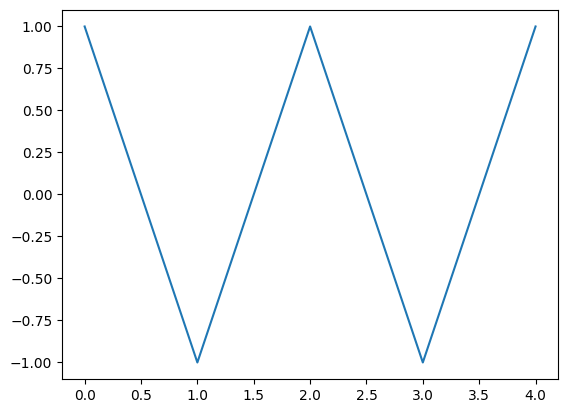

In [13]:
fig = plt.figure()
ax = plt.axes()
lines = {
    'line1': ax.plot([0,1,2,3,4],[1,-1,1,-1,1])[0]
}
x0 = np.array([[0,1,2,3],[4,5,6,7]])
print(x0[0,1])
print(x0[0][1])

In [36]:
x0 = DefBodiesDict.get('Body Elements')
x1 = x0[:,0:3]
x2 = x0[:,3:6]
print('< \n {} \n >'.format(x0))
print('< \n {} \n >'.format(x1))
print('< \n {} \n >'.format(x2))

< 
 [[ 1.95683334e-01 -2.07967708e-01  8.89114822e-02  1.00287582e-06
   7.10261281e-07 -4.62358562e-07]
 [-1.12774495e+02  1.37769404e+02 -6.15442605e+01 -1.11522197e-02
  -7.32502779e-03  4.48190526e-03]
 [-2.37504674e+02  4.38287375e+00  2.07516961e+01  3.41979024e-04
  -1.11706534e-02  5.81982969e-03]
 [-2.16465458e+02 -1.68425522e+02  1.07915081e+02  7.61827803e-03
  -7.81392642e-03  3.11628009e-03]
 [-1.78507630e+02 -2.87400621e+02  1.67876593e+02  8.79997358e-03
  -4.55139058e-03  1.52685661e-03]
 [-4.20266046e+02  2.97492400e+02 -1.13714237e+02 -5.06391274e-03
  -5.78324263e-03  3.56885352e-03]
 [-7.76758503e+02  9.02355914e+02 -3.89577017e+02 -4.27821397e-03
  -2.78299533e-03  1.85622920e-03]
 [-2.93445621e+03 -1.90942637e+03  1.04088540e+03  1.82417062e-03
  -2.59469624e-03  2.47649163e-04]] 
 >
< 
 [[ 1.95683334e-01 -2.07967708e-01  8.89114822e-02]
 [-1.12774495e+02  1.37769404e+02 -6.15442605e+01]
 [-2.37504674e+02  4.38287375e+00  2.07516961e+01]
 [-2.16465458e+02 -1.68425